# Download and import libraries

In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
import torch
import torchvision
import numpy as np
import time

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from torchvision import models

from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# Data processing




## Download Cifar-10

In [ ]:
training_data = datasets.CIFAR10(
    root="cifar_data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="cifar_data",
    train=False,
    download=True,
    transform=ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 43228335.90it/s]


Extracting cifar_data/cifar-10-python.tar.gz to cifar_data
Files already downloaded and verified


## Perform augmentation

In [ ]:
transform_training = v2.Compose([
    v2.Resize((150, 150)),
    v2.RandomCrop((128, 128)),
    v2.RandomHorizontalFlip(p=0.2),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = v2.Compose([
    v2.Resize((150, 150)),
    v2.CenterCrop((128, 128)),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# augmentation doesn't change dataself itself, it will be applied to each batch when training

training_data_aug = datasets.CIFAR10(
    root="cifar_data_augmented",
    train=True,
    download=True,
    transform=transform_training
)

test_data_aug = datasets.CIFAR10(
    root="cifar_data_augmented",
    train=False,
    download=True,
    transform=transform_test
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:05<00:00, 30463606.83it/s]


Extracting cifar_data_augmented/cifar-10-python.tar.gz to cifar_data_augmented
Files already downloaded and verified


##Display unaugmented train data

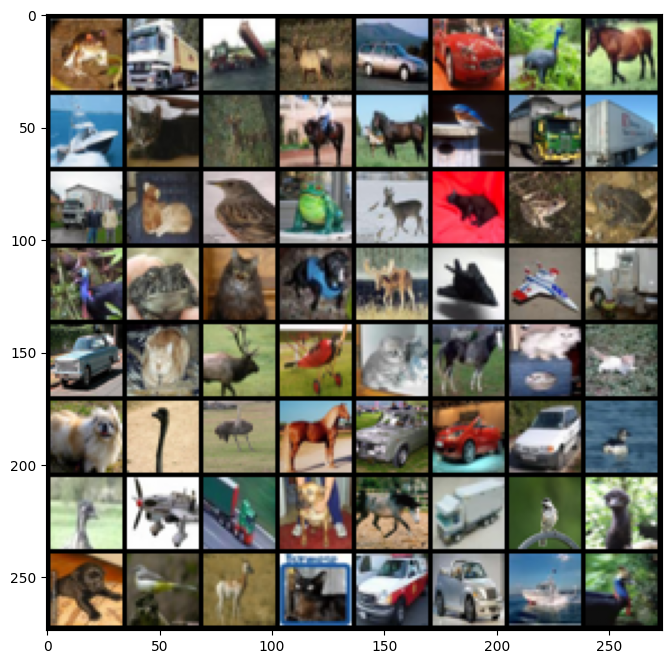

In [ ]:
data = torch.tensor(training_data.data[:64]).float().permute(0, 3, 1, 2)
image_grid = torchvision.utils.make_grid(data, normalize=True)

plt.figure(figsize=(8,8))
plt.imshow(image_grid.permute(1, 2, 0))

## Display augmented train data

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


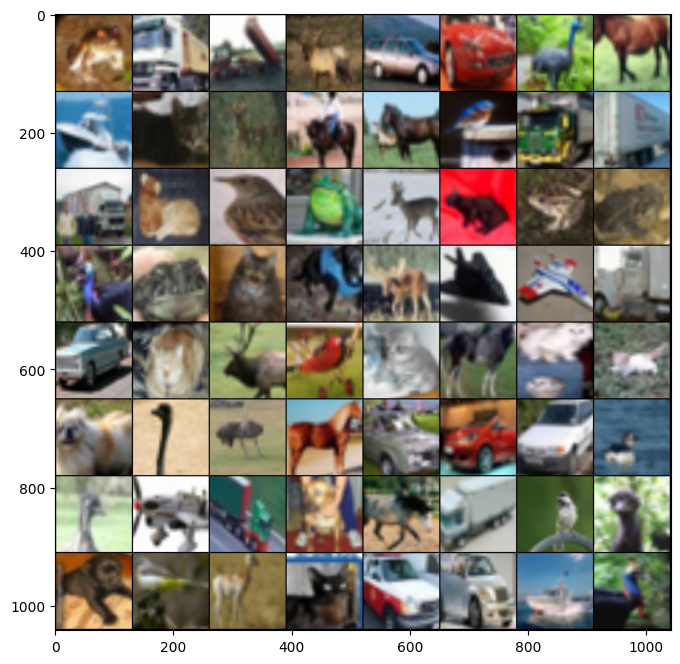

In [ ]:
# notice random crop and flip

train_aug_data = [transform_training(i) for i in data]
image_grid = torchvision.utils.make_grid(train_aug_data, normalize=True)

plt.figure(figsize=(8,8))
plt.imshow(image_grid.permute(1, 2, 0))

## Display augmented test data

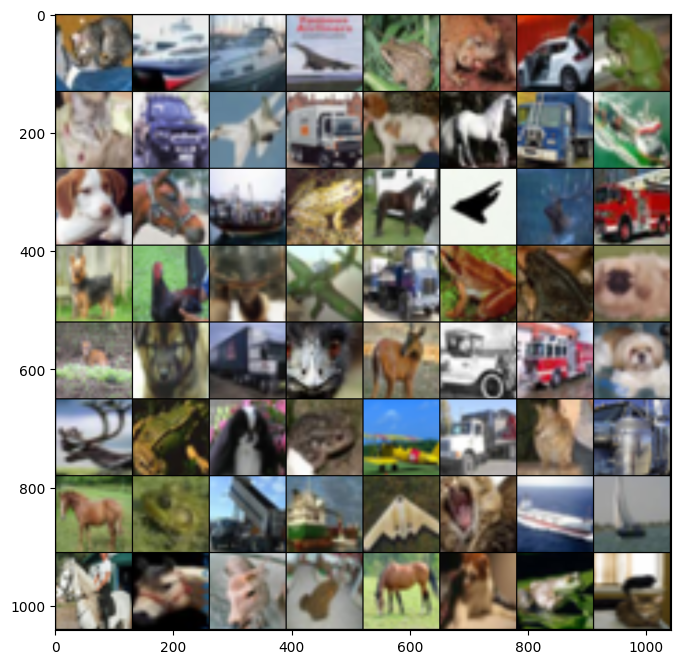

In [ ]:
# only central crop

data = torch.tensor(test_data_aug.data[:64]).float().permute(0, 3, 1, 2)
test_aug_data = [transform_test(i) for i in data]
image_grid = torchvision.utils.make_grid(test_aug_data, normalize=True)

plt.figure(figsize=(8,8))
plt.imshow(image_grid.permute(1, 2, 0))

In [ ]:
label_names = training_data_aug.classes

print("Unique image labels in the CIFAR-10 trainset:")
print(label_names)

Unique image labels in the CIFAR-10 trainset:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# ResNet18 model training/fine-tuning

In [ ]:
# get model from torch and change last layer as per our classification objective
def get_model(freeze_num_layers=None):

    resnet = models.resnet18(weights='DEFAULT')
    if freeze_num_layers: # num first layers to freeze
      for layer, child in enumerate(model.children()):

        if layer <= freeze_num_layers:
          for param in child.parameters():
            param.requires_grad = False

    num_ftrs = resnet.fc.in_features

    # Replace the final classification layer with a new one for CIFAR-10 (10 classes)
    resnet.fc = torch.nn.Linear(num_ftrs, 10)
    return resnet

def train(net, train_dataloader, valid_dataloader, criterion, optimizer, epochs=10, device='cpu', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        print(f'Training loss: {running_loss / len(trainloader):.2f}')

        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

def get_accuracy(test_dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Accuracy on the test set: {100 * correct / total}%")

## Training

In [ ]:
# training

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_model(freeze_num_layers=None).to(device) # freezing earlier layers doesn't help increase accuracy in this case

criterion = torch.nn.CrossEntropyLoss()
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Fine-tune ResNet on unaugmented data

In [ ]:
# fine-tune resnet on unaugmented data

trainloader = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)

net = train(model, trainloader, testloader, criterion, optimizer, 10, device)

Training for 10 epochs on cuda
Epoch 1/10
Training loss: 0.90
Valid loss: 0.80
Epoch 2/10
Training loss: 0.58
Valid loss: 0.66
Epoch 3/10
Training loss: 0.46
Valid loss: 0.75
Epoch 4/10
Training loss: 0.36
Valid loss: 0.62
Epoch 5/10
Training loss: 0.28
Valid loss: 0.69
Epoch 6/10
Training loss: 0.23
Valid loss: 0.67
Epoch 7/10
Training loss: 0.18
Valid loss: 0.72
Epoch 8/10
Training loss: 0.15
Valid loss: 0.83
Epoch 9/10
Training loss: 0.13
Valid loss: 0.75
Epoch 10/10
Training loss: 0.11
Valid loss: 0.75
Total training time: 148.9 seconds


In [ ]:
get_accuracy(testloader)

Accuracy on the test set: 81.25%


## Fine-tune ResNet on augmented data

In [ ]:
# fine-tune resnet on augmented data

trainloader = torch.utils.data.DataLoader(training_data_aug, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data_aug, batch_size=128, shuffle=False, num_workers=4)

net = train(model, trainloader, testloader, criterion, optimizer, 10, device)

Training for 10 epochs on cuda
Epoch 1/10
Training loss: 0.93
Valid loss: 0.69
Epoch 2/10
Training loss: 0.51
Valid loss: 0.48
Epoch 3/10
Training loss: 0.39
Valid loss: 0.40
Epoch 4/10
Training loss: 0.33
Valid loss: 0.38
Epoch 5/10
Training loss: 0.28
Valid loss: 0.35
Epoch 6/10
Training loss: 0.24
Valid loss: 0.38
Epoch 7/10
Training loss: 0.21
Valid loss: 0.29
Epoch 8/10
Training loss: 0.19
Valid loss: 0.34
Epoch 9/10
Training loss: 0.18
Valid loss: 0.31
Epoch 10/10
Training loss: 0.15
Valid loss: 0.32
Total training time: 730.2 seconds


In [ ]:
get_accuracy(testloader)

Accuracy on the test set: 89.81%
